In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import math
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import time

In [6]:
data = pd.read_csv("training_variants")
print("datapoints -> ",data.shape[0])
print("features -> ",data.shape[1])
print("Features :",data.columns.values)
data.head()

datapoints ->  3321
features ->  4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [11]:
data_text = pd.read_csv("training_text",sep = "\|\|",names = ["ID","TEXT"],skiprows=1)

In [13]:
print(data_text.shape)
data_text.head()

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [21]:
stopwords_ = set(stopwords.words('english'))
def word_preprocessing(text,index,col):
    if type(text) is not int:
        string = ""
        text = re.sub("[^a-zA-z0-9\n]"," ",text)
        text = re.sub("\s+"," ",text)
        text = text.lower()
        for word in text.split():
            if not word in stopwords_:
                string += word + " "
        data_text[col][index] = string

In [22]:
start_time = time.clock()
for index,row in data_text.iterrows():
    if type(row['TEXT']) is str:
        word_preprocessing(row['TEXT'],index,'TEXT')
    else:
        print("text is not a string ",index)
print("time taken -> ",time.clock()-start_time,"seconds")

text is not a string  1109
text is not a string  1277
text is not a string  1407
text is not a string  1639
text is not a string  2755
time taken ->  132.259635291 seconds


In [23]:
real_data = pd.merge(data,data_text,how = 'left',on = 'ID')
real_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [32]:
real_data.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [25]:
real_data[real_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [36]:
real_data.loc[real_data['TEXT'].isnull(),'TEXT'] = real_data['Gene'] + real_data['Variation']

In [38]:
real_data.iloc[1109]

ID                  1109
Gene               FANCA
Variation         S1088F
Class                  1
TEXT         FANCAS1088F
Name: 1109, dtype: object

In [61]:
y_label = real_data['Class'].values
#real_data['Gene'] = real_data['Gene'].str.replace('\s+','_')
#real_data['Gene'] = real_data['Gene'].str.replace('\s+','_')
new_real_data = real_data.drop(labels = 'Class',axis=1)

In [72]:
X_train,X_test,y_train,y_test = train_test_split(real_data,y_label,stratify = y_label,test_size = 0.2)
X_train_df,X_cv,y_train_df,y_cv = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [76]:
# distribution of classes in train,cv and test datasets
train_dist = X_train_df['Class'].value_counts().sortlevel()
cv_dist = X_cv['Class'].value_counts().sortlevel()
test_dist = X_test['Class'].value_counts().sortlevel()

In [101]:
def class_counts(df,col):
    total = df[col].value_counts().values.sum()
    ind_val_prct = pd.DataFrame((df[col].value_counts().values*100)/total)
    df = pd.DataFrame(df[col].value_counts().index)
    df = pd.concat([df,ind_val_prct],axis =1,names = ['Class','percentage'])
    return(df)

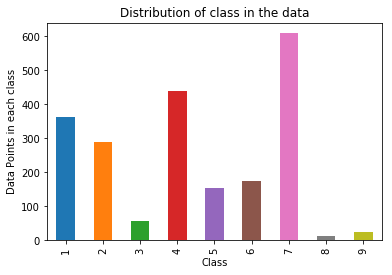

   0          0
0  7  28.672316
1  4  20.668550
2  1  17.090395
3  2  13.606403
4  6   8.286252
5  5   7.297552
6  3   2.683616
7  9   1.129944
8  8   0.564972


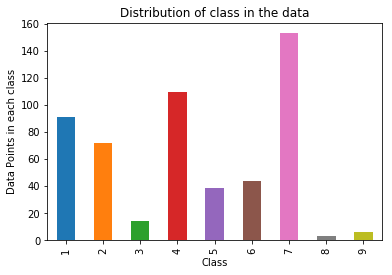

   0          0
0  7  28.759398
1  4  20.676692
2  1  17.105263
3  2  13.533835
4  6   8.270677
5  5   7.330827
6  3   2.631579
7  9   1.127820
8  8   0.563910


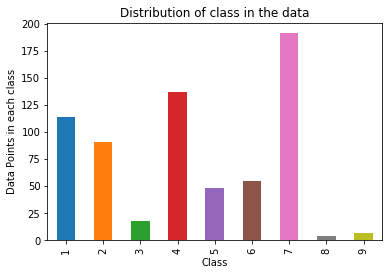

   0          0
0  7  28.721805
1  4  20.601504
2  1  17.142857
3  2  13.684211
4  6   8.270677
5  5   7.218045
6  3   2.706767
7  9   1.052632
8  8   0.601504


In [110]:
train_dist.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data Points in each class')
plt.title("Distribution of class in the data")
plt.show()
print(class_counts(X_train_df,'Class'))

cv_dist.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data Points in each class')
plt.title("Distribution of class in the data")
plt.show()

print(class_counts(X_cv,'Class'))

test_dist.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data Points in each class')
plt.title("Distribution of class in the data")
plt.show()

print(class_counts(X_test,'Class'))

In [ ]:
def plot_confusion_matrix(y_test,y_pred):
    